### Ticker Technical Analysis 
Uses ticker pricing data for given date range and analyzes the buy and sell signals. 

In [102]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta

In [103]:
# get tomorrows date so we can use this in the yf.download as an end date

date = datetime.now() + timedelta(days=1)
fmt_date = date.strftime('%Y-%m-%d')
fmt_date

'2024-10-12'

In [104]:
# enter ticker symbol and date range to retrieve

ticker = 'ai'
start_date = '2024-09-25'
end_date =  fmt_date

In [105]:
# Fetch data for a ticker via yahoo api 

df_intra = yf.download(ticker, start_date, end_date, interval='60m', progress=False)
df = yf.download(ticker, start_date, end_date, progress=False)

In [106]:
# EMA - Calculates the Daily EMA, Intra-Day EMA & stores it to respective dataframes

def calculate_ema(fast_ema, slow_ema, data_set):
    fema = data_set['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = data_set['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

# call calculate_ema and pass in the ema values and data sets
df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)
df_intra['EMA_A'], df_intra['EMA_B'] = calculate_ema(5, 7, df_intra)


In [107]:
# RSI - Calulates the RSI and adds median_rsi and RSI to respective dataframes

def calculate_rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    dataset['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

    dataset['rsi'] = rsi

    return rs, rsi, median_rsi


my_rsi_values = calculate_rsi(df, 10, 90)
my_irsi_values = calculate_rsi(df_intra, 10, 90)

In [108]:
df_intra.tail(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Datetime,,,,,,,,,,
2024-10-11 11:30:00,26.709999,27.025000,26.660000,26.900000,26.900000,925081,26.498975,26.362664,above_median,81.135691
2024-10-11 12:30:00,26.910000,27.020000,26.740000,26.980000,26.980000,422836,26.659316,26.516998,above_median,82.118209
2024-10-11 13:30:00,26.980000,27.339899,26.950001,27.260000,27.260000,1020738,26.859544,26.702748,above_median,85.225784
2024-10-11 14:30:00,27.260000,27.475000,27.209999,27.334999,27.334999,760272,27.018029,26.860811,above_median,85.978857
2024-10-11 15:30:00,27.340000,27.469999,27.240000,27.240000,27.240000,892069,27.092019,26.955608,above_median,80.017672


In [109]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)
df_intra['MACD'], df_intra['Signal'] = calculate_macd(df_intra)

In [110]:
# # debug code

# closing_prices = df[['Close', 'MACD', 'Signal']]
# closing_prices.tail(60)

In [111]:
# Calculate Signal

def signal(data_set):
    rsi_check = data_set['Median_RSI'] == 'above_median'
    crossed_above_with_rsi = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) & (rsi_check)
    crossed_above = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) 
    crossed_above_macd = (data_set['MACD'] > data_set['Signal']) & (data_set['MACD'].shift(1) <= data_set['Signal'].shift(1))
    return crossed_above_with_rsi, crossed_above, crossed_above_macd

# Capture the output of the signal function
crossed_above_with_rsi, crossed_above, crossed_above_macd = signal(df)
icrossed_above_with_rsi, icrossed_above, icrossed_above_macd = signal(df_intra)

### Result of the Signal function: 
will be added to dataframe & also the condition for crossed down.

In [112]:
def algo_result(dataset, indctr1, indctr2, indctr3):
    # DAILY - This uses the result of the choice of indctrs.  
    dataset.loc[indctr1, 'Cross_Direction'] = 'crossed up'

    # Identify when the A-day EMA crosses below the B-Day EMA
    crossed_below = (dataset['EMA_A'] < dataset['EMA_B']) & (dataset['EMA_A'].shift(1) > dataset['EMA_B'].shift(1))
    dataset.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

    # Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
    condition_met = dataset[dataset['Cross_Direction'].notna()]

    return condition_met

In [113]:
# INTER DAY - pass in the arguments for condition_met
condition_met = algo_result(df, crossed_above_with_rsi, crossed_above, crossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-10-01,22.6,23.685185,23.813711,crossed down,below_median,7.699518
2024-10-07,24.1,23.735592,23.727581,crossed up,above_median,57.050597


In [114]:
# INTRA DAY - pass in the arguments for condition_met
icondition_met = algo_result(df_intra, icrossed_above_with_rsi, icrossed_above, icrossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
icondition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Datetime,,,,,,
2024-09-27 14:30:00,24.125000,24.231789,24.244070,crossed down,below_median,44.579149
2024-09-30 10:30:00,24.330000,24.270200,24.265813,crossed up,above_median,57.950135
2024-09-30 12:30:00,24.190001,24.250534,24.253645,crossed down,below_median,46.401565
2024-10-02 14:30:00,22.939800,23.044509,23.057033,crossed down,below_median,40.843141
2024-10-04 09:30:00,23.180000,23.019422,23.002630,crossed up,above_median,58.686237


### Plot 'crossed up' and 'crossed down' signals on line graph, and calculate total return


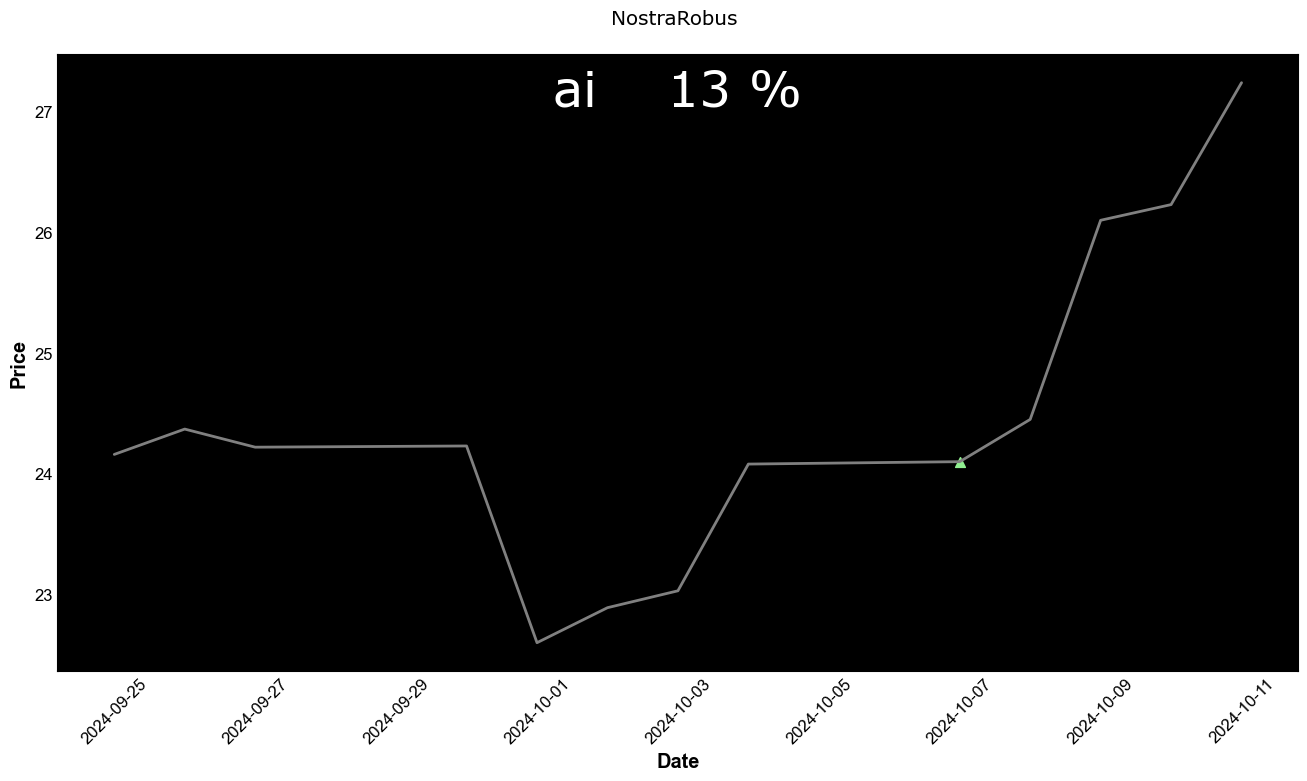

Results For Ticker:   ai
Initial Investment:  24.100000381469727
Final Portfolio Value:  27
Profit/Loss:  3.1
Percent: 13.0%




,Action,Date,Open,Close,Price,Cash
0,Buy,2024-10-07,24.049999,24.1,24.1,0.0


In [115]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = '' # not being used
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans # not being used

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black
plt.xticks(rotation=45)




# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
last_close_price = df['Close'].iloc[-1] #get last close price in order to calc our return
portfolio_value =  last_close_price - cash  #portfolio value is our initial purchase price minus last close price.
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment # net difference of our investment and final close price
percent = (profit_loss / initial_investment) * 100 # profit_loss as percent of investment

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



### Same calculation as line graph but with candlestick graph

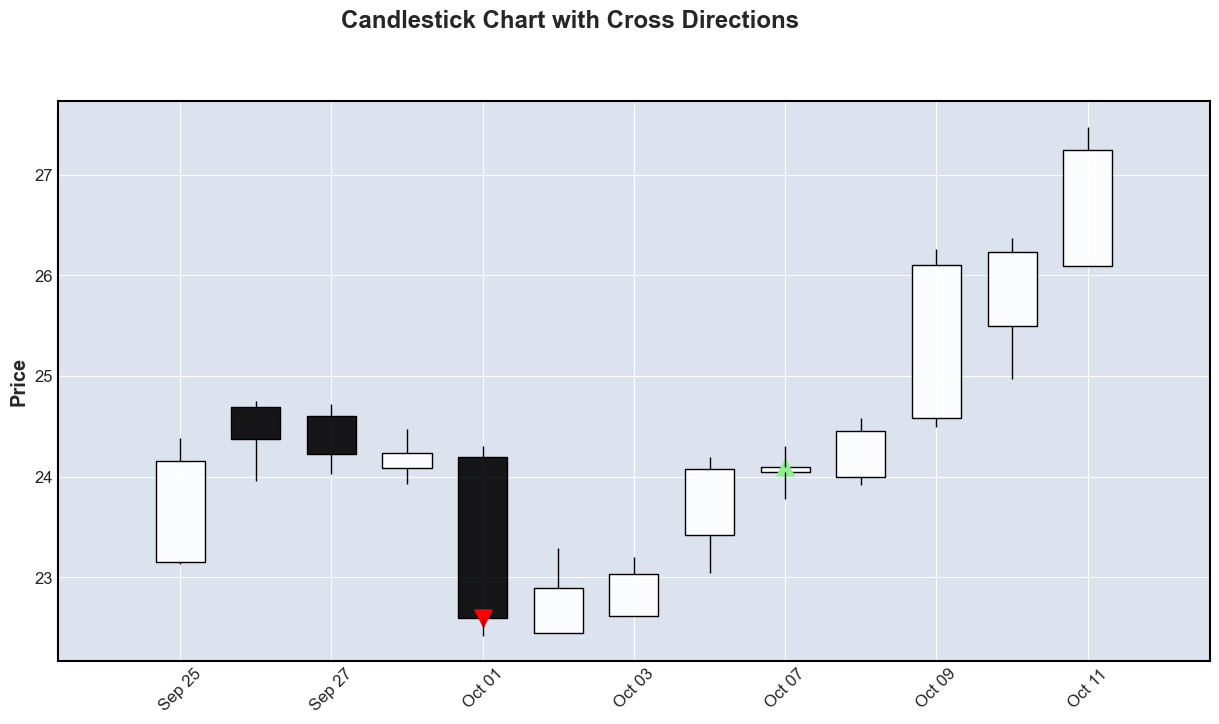

In [116]:
# Plot the candlestick chart with the custom black background
mpf.plot(
    df,
    type='candle',
    title='Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed up', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed down', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


### Intraday Candlestick Graph

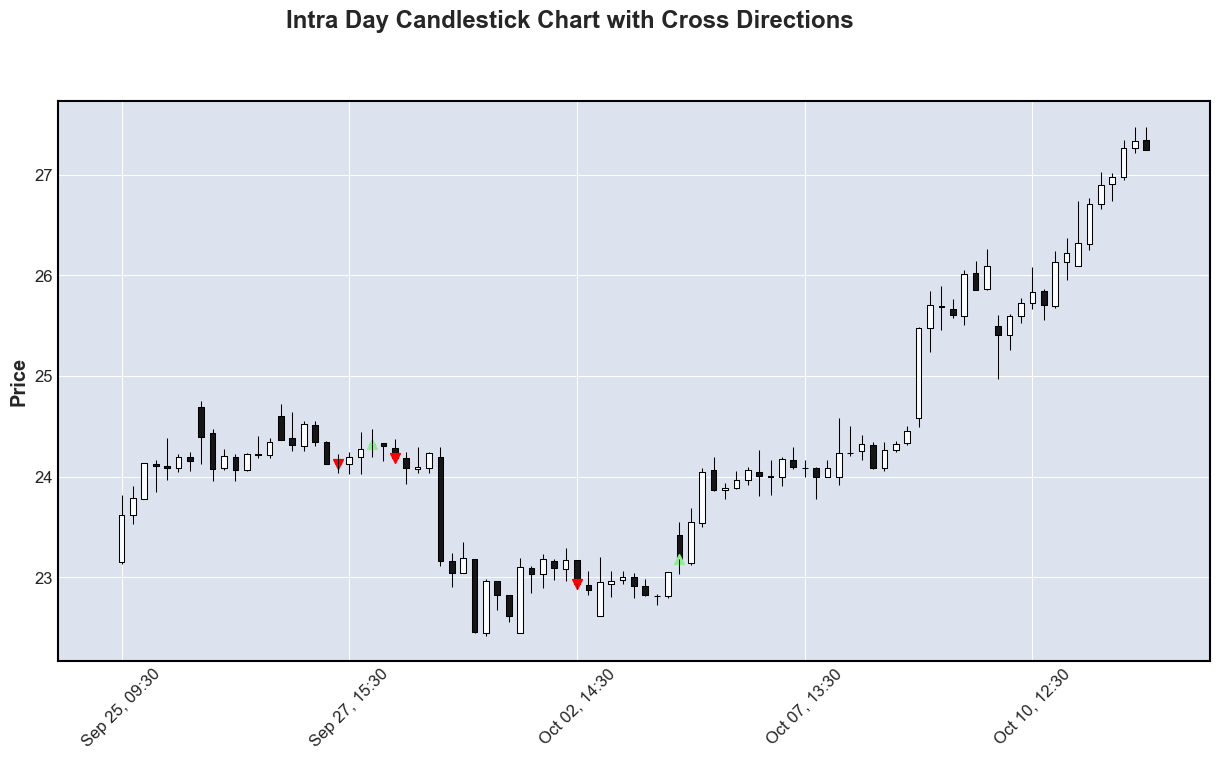

In [127]:
# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    df_intra,
    type='candle',
    title='Intra Day Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_intra) + 1,
    addplot=[
        mpf.make_addplot(
            np.where(df_intra['Cross_Direction'] == 'crossed up', df_intra['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for 'crossed up'
            markersize=50,  # Marker size
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df_intra['Cross_Direction'] == 'crossed down', df_intra['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for 'crossed down'
            markersize=50,  # Marker size
            color='red'      # Color for 'crossed down'
        )
    ]
)